In [2]:
import numba, numpy as np, matplotlib.pyplot as plt
from matplotlib import animation

plt.style.use(['science', 'notebook', 'grid', 'dark_background'])

The Spaciotemporal change for a species over time can be described as $$\frac{\partial \rho}{\partial t}=D\nabla^2\rho+\alpha (\vec r) \rho-\beta \rho^2$$ where
- $\rho=\rho(\vec r, t)$ is the Number Density of a species at a Position $\vec r$ and Time $t$.
- $D$ is the Diffusion Rate.
- $\alpha=\alpha(\vec r)$ is the Abundance of Resources at Position $\vec r$.
- The Rightmost term represents the Death of a Species, through both natural causes and competition among other organisms. 

Multiplying by $\beta$ and introducting $u=\beta \rho$, we have $$\frac{\partial u}{\partial t}=D\nabla^2u+\alpha (\vec r)u-u^2$$ and in 1 dimension: $$\frac{\partial u}{\partial t}=d\frac{\partial^2 u}{\partial x^2}+u(r(x)-u)$$

If two species with Normalized Densities $u$ and $v$ and Relative Competing Strengths $a$ and $b$, and if $a<b$:$$\frac{\partial u}{\partial t}=d_1\frac{\partial^2 u}{\partial x^2}+u(r(x)-u-av)$$ $$\frac{\partial v}{\partial t}=d_2\frac{\partial^2 v}{\partial x^2}+v(r(x)-bu-v)$$ After making an approximation with $\delta x$ and $\delta t$, we get $$u_{i}^{m+1}=u_{i}^m+\frac{d_1\delta t}{\delta x^2}(u_{i+1}^m+u_{i-1}^m-2u_i^m)+u_i^m(r_i-u_i^m-av_i^m)\delta t$$ $$v_{i}^{m+1}=v_{i}^m+\frac{d_2\delta t}{\delta x^2}(v_{i+1}^m+v_{i-1}^m-2v_i^m)+v_i^m(r_i-v_i^m-bu_i^m)\delta t$$ where
- $i$ is the Position Index.
- $m$ is the Time Index.
- These two form a grid of points which, at time $m+1$ depend only on those at time $m$.

In [3]:
times = np.linspace(0, 140, 200000)
x = np.linspace(-2, 2, 60)

u = np.zeros([len(times), len(x)])
v = np.zeros([len(times), len(x)])

r = np.exp(-x ** 2 / 0.1)

config = 3  # CHANGE THIS AS YOU PLEASE

if config == 1:
    u[0] = np.exp(-(x - 1) ** 2 / 0.02)
    v[0] = np.exp(-(x + 1.2) ** 2 / 0.02)

    d1, d2, a, b = 0.01, 0.01, 1, 1


elif config == 2:
    u[0] = np.exp(-(x - 1.2) ** 2 / 0.02)
    v[0] = np.exp(-(x + 1.2) ** 2 / 0.02)

    d1, d2, a, b = 0.001, 0.01, 1, 1

elif config == 3:
    u[0] = np.exp(-(x - 1.2) ** 2 / 0.02)
    v[0] = np.exp(-(x + 1.2) ** 2 / 0.02)

    d1, d2, a, b = 0.01, 0.01, 1, 0.5

elif config == 4:
    u[0] = np.exp(-(x - 1.2) ** 2 / 0.02)
    v[0] = np.exp(-(x + 1.2) ** 2 / 0.02)

    d1, d2, a, b = 0.01, 0.1, 1, 0.5


dx, dt = np.diff(x)[0], np.diff(times)[0]

Text(0, 0.5, '$u, v$ [Number Density]')

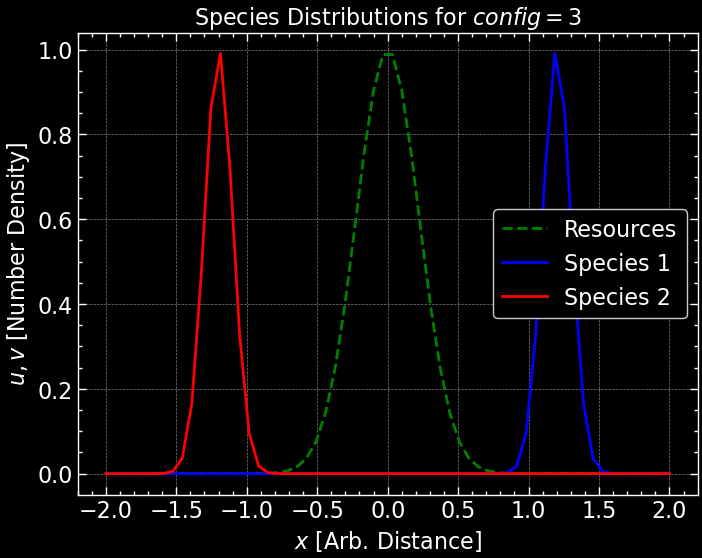

In [4]:
plt.plot(x, r, ls = '--', label = 'Resources', color = 'green')
plt.plot(x, u[0], label = 'Species 1', color = 'blue')
plt.plot(x, v[0], label = 'Species 2', color = 'red')

plt.title(r'Species Distributions for $config={}$'.format(config))
plt.legend()
plt.xlabel(r'$x$ [Arb. Distance]')
plt.ylabel(r'$u, v$ [Number Density]')

In [5]:
@numba.jit('UniTuple(f8[:,:], 2)(f8[:,:], f8[:,:], f8[:])', nopython = True, nogil = True)
def solve_pop(u, v, r):
    for t in range(0, len(times) - 1):
        for i in range(0, len(u[0])):
            if i == 0:
                deriv2_1 = 2 * u[t][i + 1] - 2 * u[t][i]
                deriv2_2 = 2 * v[t][i + 1] - 2 * v[t][i]
            elif i == len(u[0]) - 1:
                deriv2_1 = 2 * u[t][i - 1] - 2 * u[t][i]
                deriv2_2 = 2 * v[t][i - 1] - 2 * v[t][i]
            else:
                deriv2_1 = u[t][i + 1] + u[t][i - 1] - 2 * u[t][i]
                deriv2_2 = v[t][i + 1] + v[t][i - 1] - 2 * v[t][i]
            
            u[t + 1][i] = u[t][i] + d1 * dt / dx ** 2 * deriv2_1 + \
                          u[t][i] * dt * (r[i] - u[t][i] - a * v[t][i])
            v[t + 1][i] = v[t][i] + d2 * dt / dx ** 2 * deriv2_2 + \
                          v[t][i] * dt * (r[i] - v[t][i] - b * u[t][i])

    return u, v

u, v = solve_pop(u, v, r)


Text(0, 0.5, '$u, v$ [Number Density]')

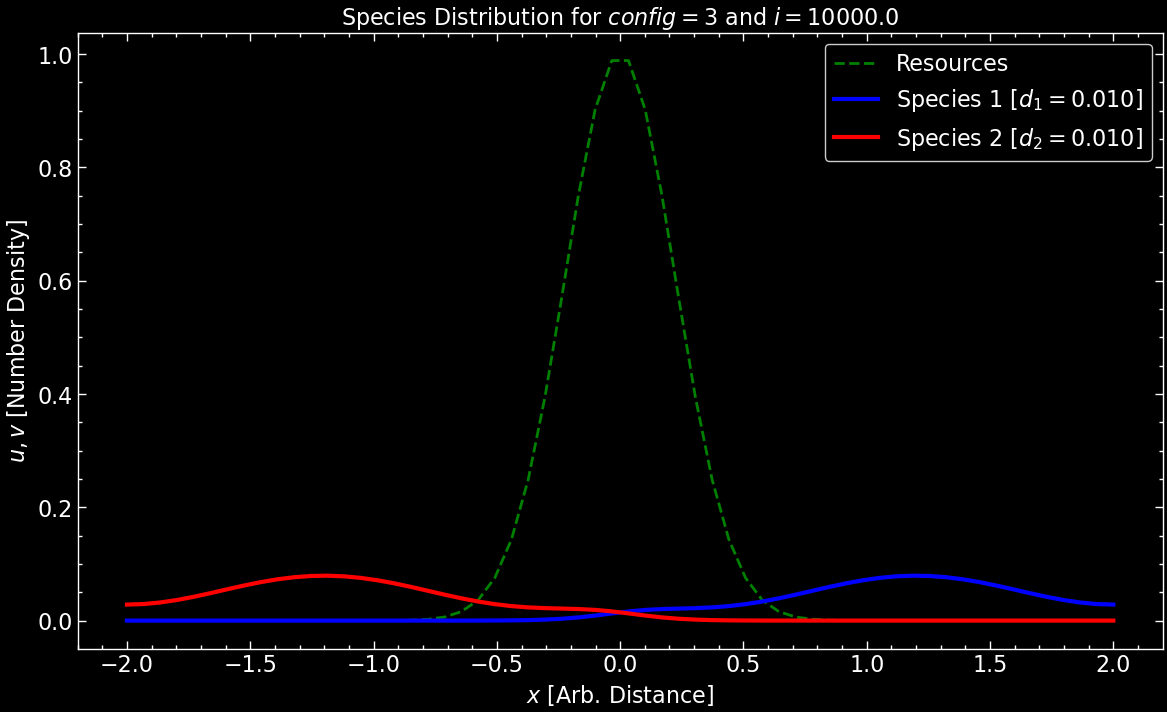

In [6]:
i = 10000 # CHANGE THIS AS YOU PLEASE

plt.figure(figsize = (14, 8))

plt.plot(x, r, ls = '--', label = 'Resources', color = 'green')
plt.plot(x, u[i], lw = 3, label = r'Species 1 [$d_1=${:.3f}]'.format(d1), color = 'blue')
plt.plot(x, v[i], lw = 3, label = r'Species 2 [$d_2=${:.3f}]'.format(d2), color = 'red')

plt.title(r'Species Distribution for $config={}$ and $i={:.1f}$'.format(config, i))
plt.legend()
plt.grid()
plt.xlabel(r'$x$ [Arb. Distance]')
plt.ylabel(r'$u, v$ [Number Density]')

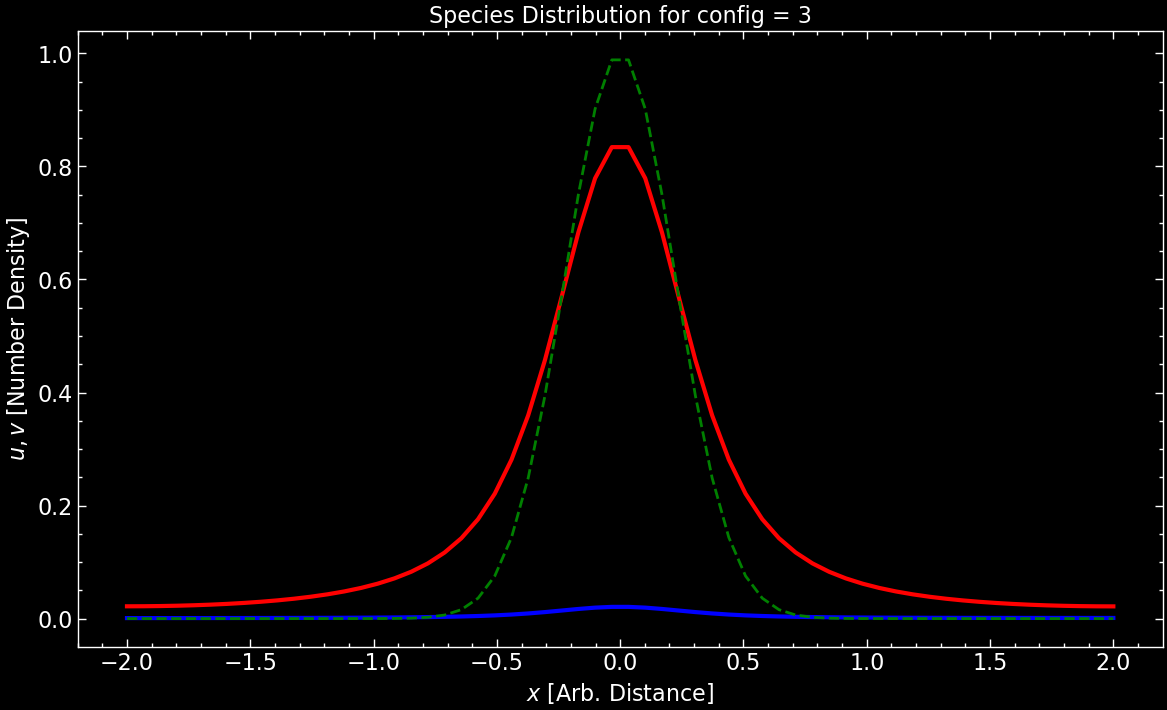

In [7]:
def animate(i):
    line1.set_data(x, u[500 * i])
    line2.set_data(x, v[500 * i])
    line3.set_data(x, r)

fig, ax = plt.subplots(1, 1, figsize = (14, 8))

ax.grid()
ax.set_title('Species Distribution for config = {}'.format(config))
ax.set_xlabel(r'$x$ [Arb. Distance]')
ax.set_ylabel(r'$u, v$ [Number Density]')

line1, = ax.plot(x, u[0], lw = 3, label = r'Species 1 [$d_1=${:.3f}]'.format(d1), color = 'blue')
line2, = ax.plot(x, u[1], lw = 3, label = r'Species 2 [$d_2=${:.3f}]'.format(d2), color = 'red')
line3, = ax.plot(x, r, ls = '--', label = 'Resources', color = 'green')

ani = animation.FuncAnimation(fig, animate, frames = 399, interval = 50)
ani.save('..\Outputs\species.gif', writer = 'pillow', fps = 10)

# Inferences:

1. The Population which starts out closer to the resources ends up outperforming the other and grows more in number.
2. They don't quite eliminate the competition, but instead reach an equilibrium which heavily favors one species over the other.
3. Aside from the interesting case of configuration #2, the species with higher diffusion rate will always end up winning.